In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [2]:
#columns = model_name,personality_1,personality_2,agent_1_scores,agent_2_scores,agent_1_messages,agent_2_messages,agent_1_actions,agent_2_actions,total_rounds
csv_path = "/cluster/home/mlindner/Github/master_thesis_project/src/data/outputs/prisoners_dilemma_250311_solved.csv"
df = pd.read_csv(csv_path, converters={
    'agent_1_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'agent_2_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'total_rounds': int
})

df['agent_1_cumulative_scores'] = df['agent_1_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))
df['agent_2_cumulative_scores'] = df['agent_2_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))

#parse as lists, something went wrong when saving the csv
df['truthful_agent_1'] = df['truthful_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['truthful_agent_2'] = df['truthful_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Parse the actions as lists of strings
df['agent_1_actions'] = df['agent_1_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_actions'] = df['agent_2_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_1_messages'] = df['agent_1_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_messages'] = df['agent_2_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_1'] = df['intent_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_2'] = df['intent_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Calculate the average cost per round for each row
df['cost_per_round'] = df['total_cost_USD'] / df['total_rounds']

## plot the final scores of each agent of each game

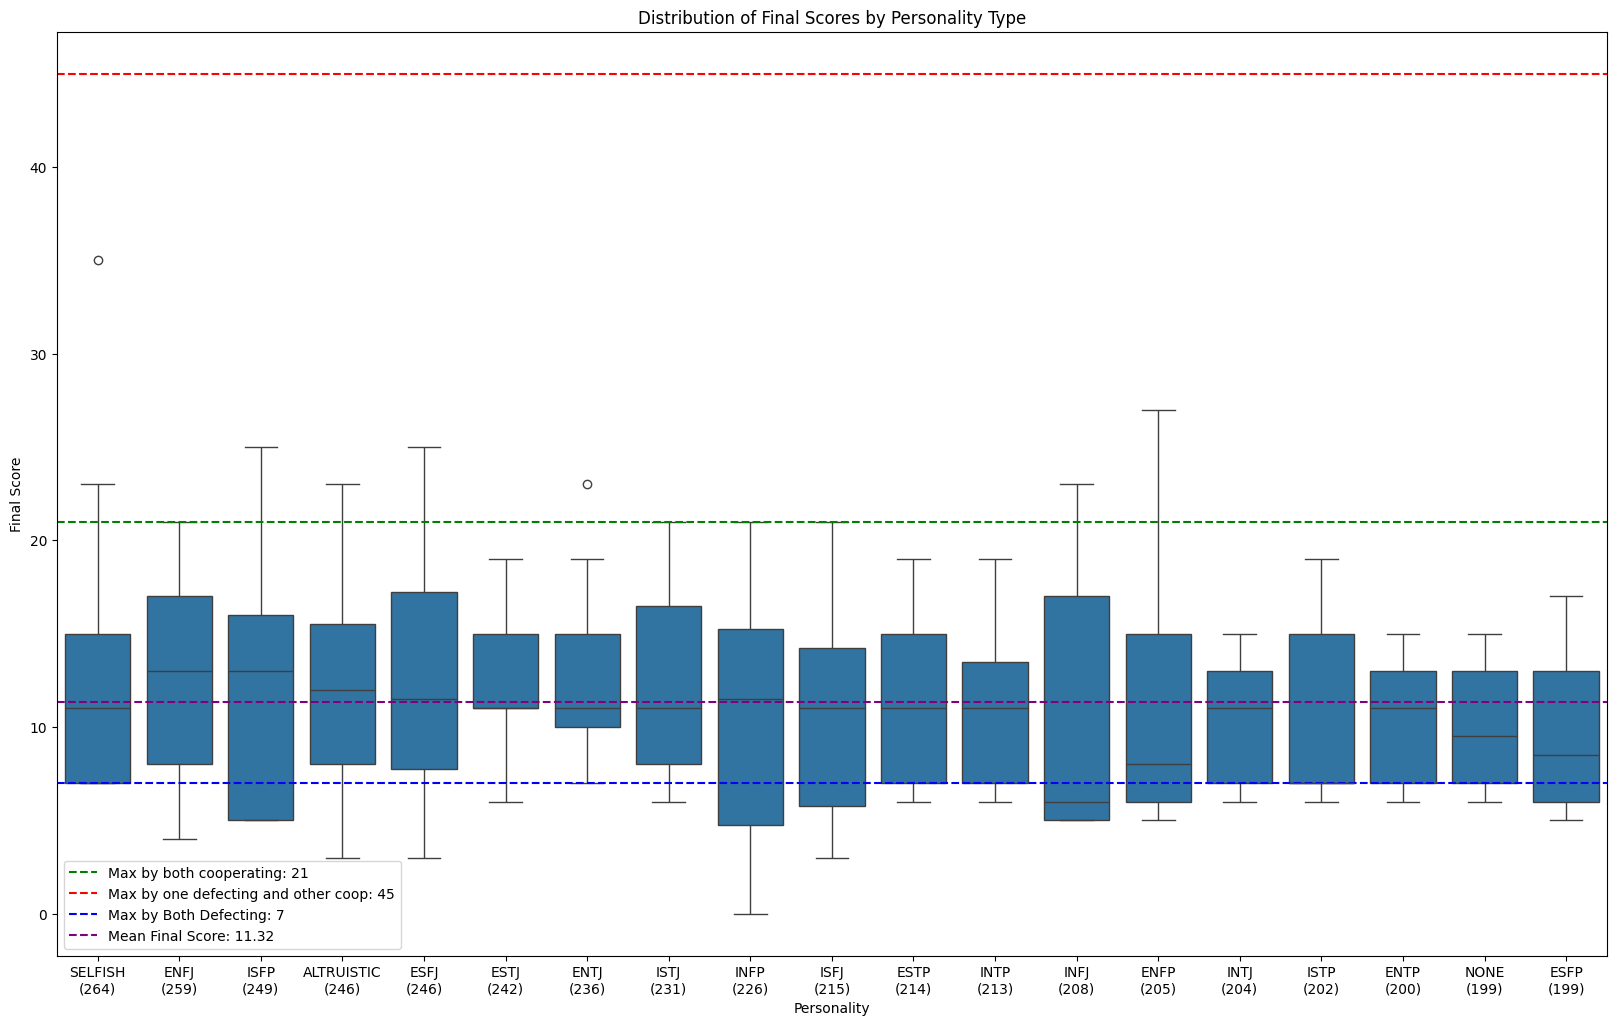

/tmp/ipykernel_1615872/1093572051.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')


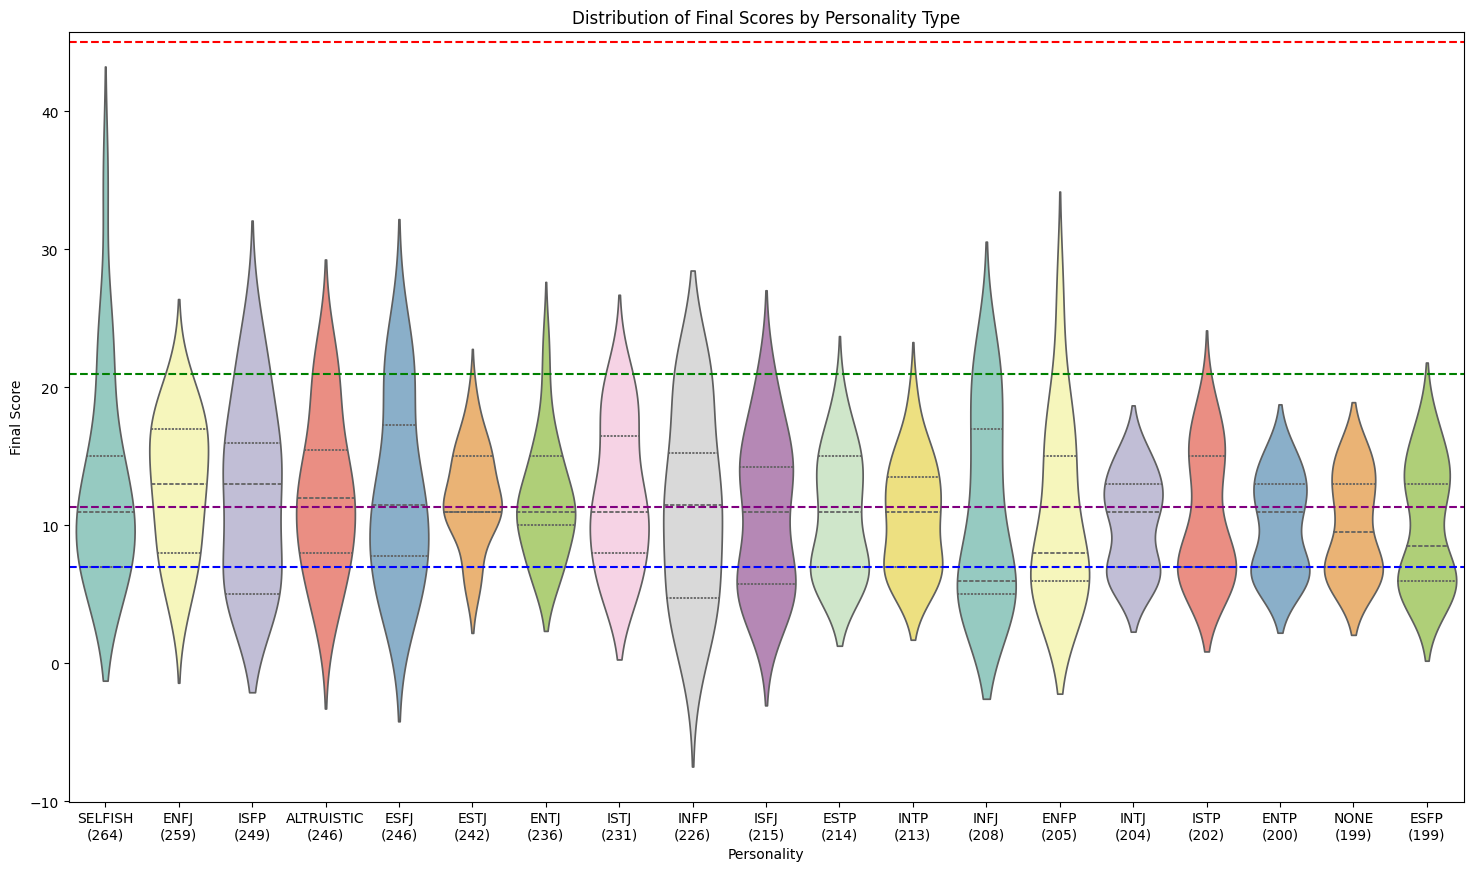

In [3]:
# Extract the final scores and personality types
final_scores = []
for i, row in df.iterrows():
    final_scores.append({'Personality': row['personality_1'], 'Final Score': row['agent_1_cumulative_scores'][-1]})
    final_scores.append({'Personality': row['personality_2'], 'Final Score': row['agent_2_cumulative_scores'][-1]})

# Create a DataFrame from the final scores
final_scores_df = pd.DataFrame(final_scores)
mean_final_score = final_scores_df['Final Score'].mean()

# Calculate total scores across all games for each personality
total_scores = final_scores_df.groupby('Personality')['Final Score'].sum().reset_index()
total_scores = total_scores.sort_values(by='Final Score', ascending=False)
total_scores_dict = total_scores.set_index('Personality')['Final Score'].to_dict()

# Sort final_scores_df by the total scores
final_scores_df['Total Score'] = final_scores_df['Personality'].map(total_scores_dict)
final_scores_df = final_scores_df.sort_values(by='Total Score', ascending=False).drop(columns=['Total Score'])

# Plot the distribution of final scores by personality type using box plot
plt.figure(figsize=(20, 12))
sns.boxplot(data=final_scores_df, x='Personality', y='Final Score')
plt.axhline(y=21, color='g', linestyle='--', label='Max by both cooperating: 21')
plt.axhline(y=45, color='r', linestyle='--', label='Max by one defecting and other coop: 45')
plt.axhline(y=7, color='b', linestyle='--', label='Max by Both Defecting: 7')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')
plt.legend()
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.show()

# Plot the distribution of final scores by personality type using violin plot
plt.figure(figsize=(18, 10))
sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

#add lines
plt.axhline(y=21, color='g', linestyle='--', label='Max by both cooperating: 21')
plt.axhline(y=45, color='r', linestyle='--', label='Max by one defecting and other coop: 45')
plt.axhline(y=7, color='b', linestyle='--', label='Max by Both Defecting: 7')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')

plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.show()

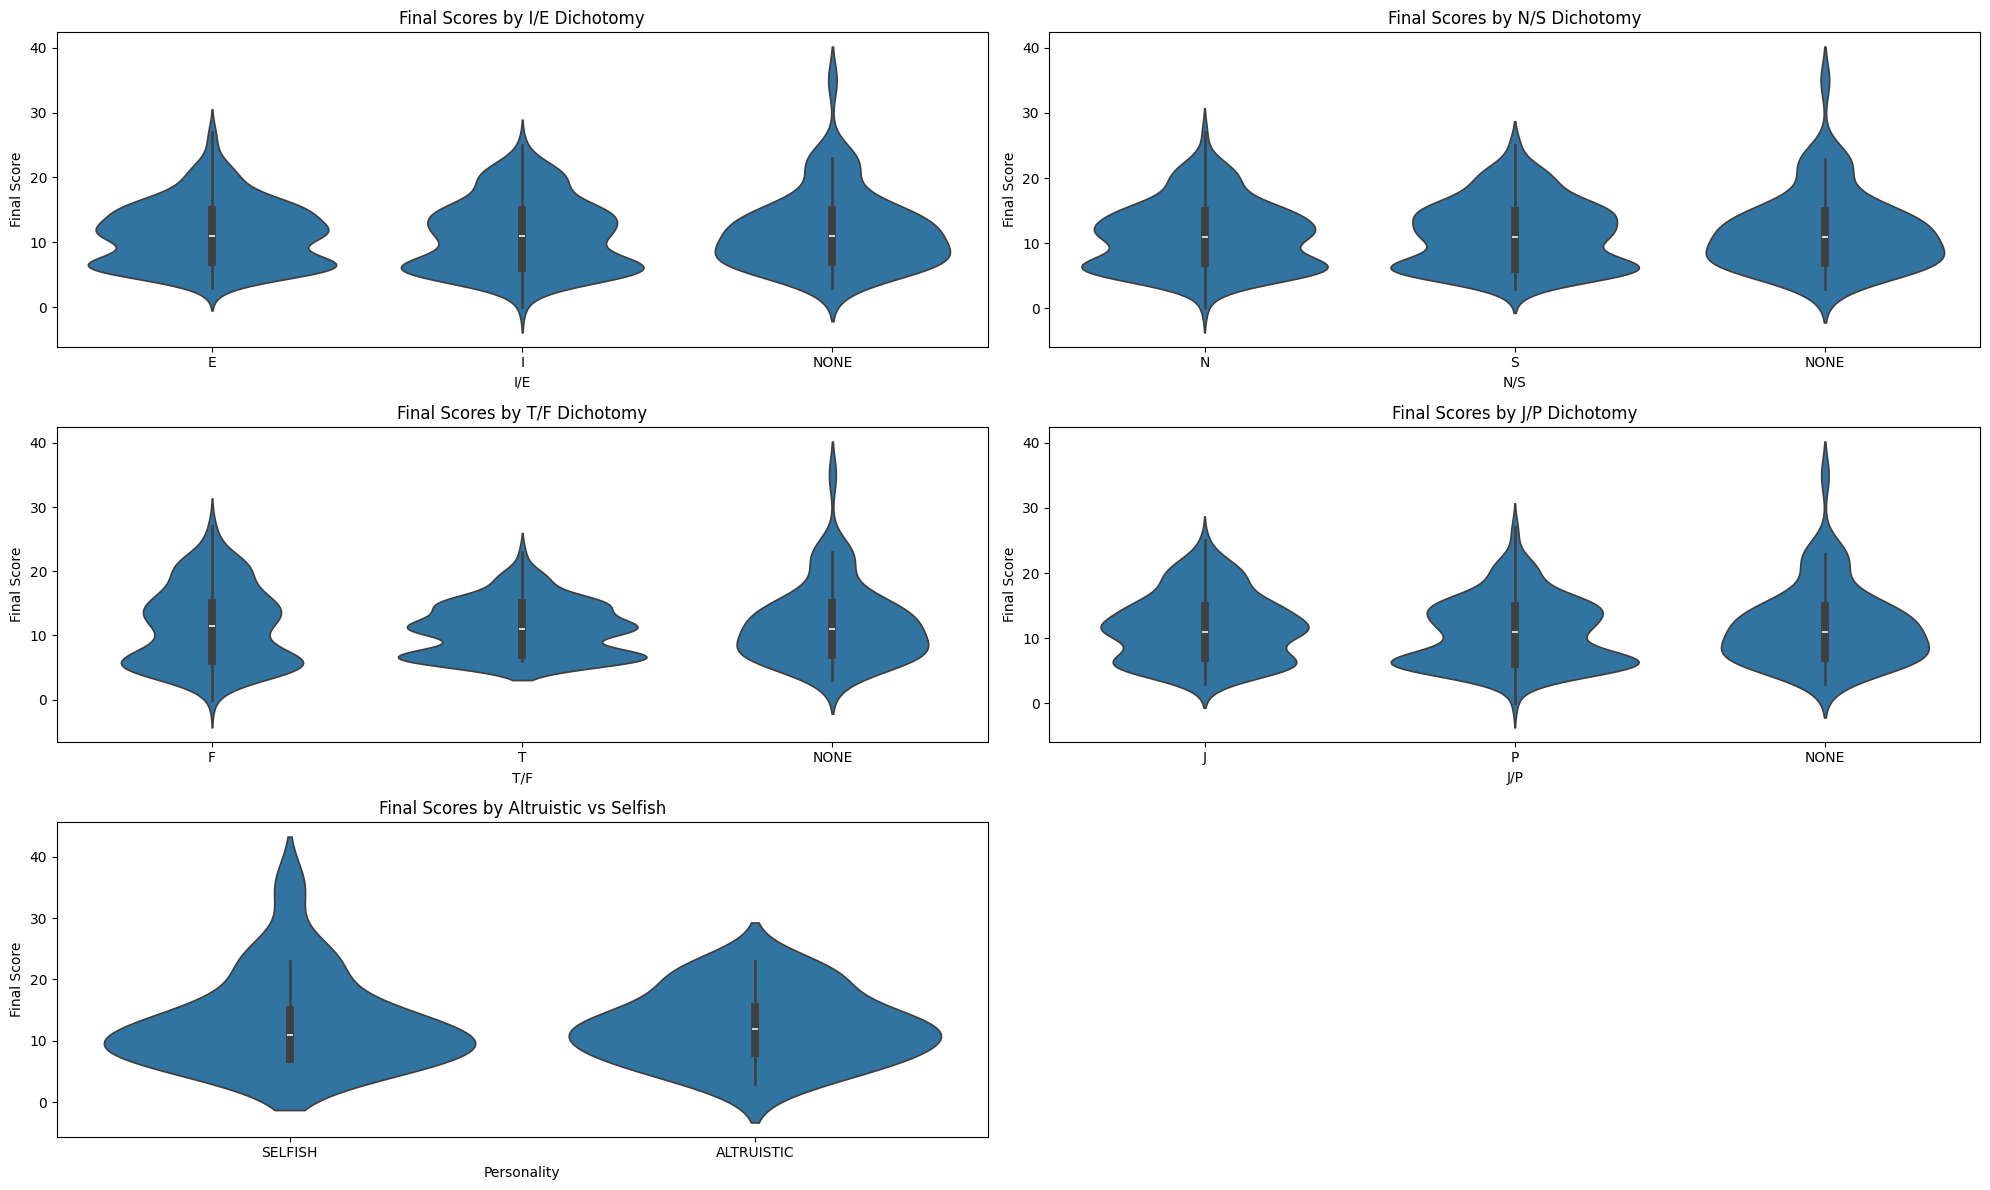

In [4]:
# Filter out the control groups
filtered_df = final_scores_df[~final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])]

# Create a new DataFrame to store the dichotomies
dichotomies_df = pd.DataFrame()

# Map each personality to its dichotomies
dichotomies_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
dichotomies_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
dichotomies_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
dichotomies_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')
dichotomies_df['Final Score'] = filtered_df['Final Score']

# Add NONE, ALTRUISTIC, and SELFISH to the dichotomies DataFrame
control_df = final_scores_df[final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])].copy()
control_df['I/E'] = 'NONE'
control_df['N/S'] = 'NONE'
control_df['T/F'] = 'NONE'
control_df['J/P'] = 'NONE'
dichotomies_df = pd.concat([dichotomies_df, control_df])

# Plot the boxplots for each dichotomy
plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
sns.violinplot(data=dichotomies_df, x='I/E', y='Final Score')
plt.title('Final Scores by I/E Dichotomy')

plt.subplot(3, 2, 2)
sns.violinplot(data=dichotomies_df, x='N/S', y='Final Score')
plt.title('Final Scores by N/S Dichotomy')

plt.subplot(3, 2, 3)
sns.violinplot(data=dichotomies_df, x='T/F', y='Final Score')
plt.title('Final Scores by T/F Dichotomy')

plt.subplot(3, 2, 4)
sns.violinplot(data=dichotomies_df, x='J/P', y='Final Score')
plt.title('Final Scores by J/P Dichotomy')

plt.subplot(3, 2, 5)
sns.violinplot(data=final_scores_df[final_scores_df['Personality'].isin(['ALTRUISTIC', 'SELFISH'])], x='Personality', y='Final Score')
plt.title('Final Scores by Altruistic vs Selfish')

plt.tight_layout()
plt.show()

## plot mean cummulative scores
some scores that start of strong, end up worse than others: guessing because agents don t tolerate repeated lying and then just defect each round as well.
Maybe with a alonger game, the difference would be even more clear.

Personality: NONE, Mean Cumulative Scores: [0.0, 2.6, 4.95, 5.95, 6.95, 7.95, 8.95, 9.95]
Personality: ISTJ, Mean Cumulative Scores: [0.0, 2.5789473684210527, 4.7894736842105265, 6.473684210526316, 8.052631578947368, 9.894736842105264, 11.210526315789474, 12.157894736842104]
Personality: ISFJ, Mean Cumulative Scores: [0.0, 1.8, 3.6, 5.55, 7.4, 8.75, 9.8, 10.75]
Personality: INFJ, Mean Cumulative Scores: [0.0, 1.4210526315789473, 3.0, 4.894736842105263, 6.473684210526316, 8.210526315789474, 9.736842105263158, 10.947368421052632]
Personality: INTJ, Mean Cumulative Scores: [0.0, 2.8, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2]
Personality: ISTP, Mean Cumulative Scores: [0.0, 2.210526315789474, 4.157894736842105, 5.7894736842105265, 7.421052631578948, 8.631578947368421, 9.631578947368421, 10.631578947368421]
Personality: ISFP, Mean Cumulative Scores: [0.0, 2.1, 4.05, 6.05, 8.0, 9.6, 10.95, 12.45]
Personality: INFP, Mean Cumulative Scores: [0.0, 2.1, 3.9, 5.7, 7.45, 8.75, 10.0, 11.3]
Personality: INTP, 

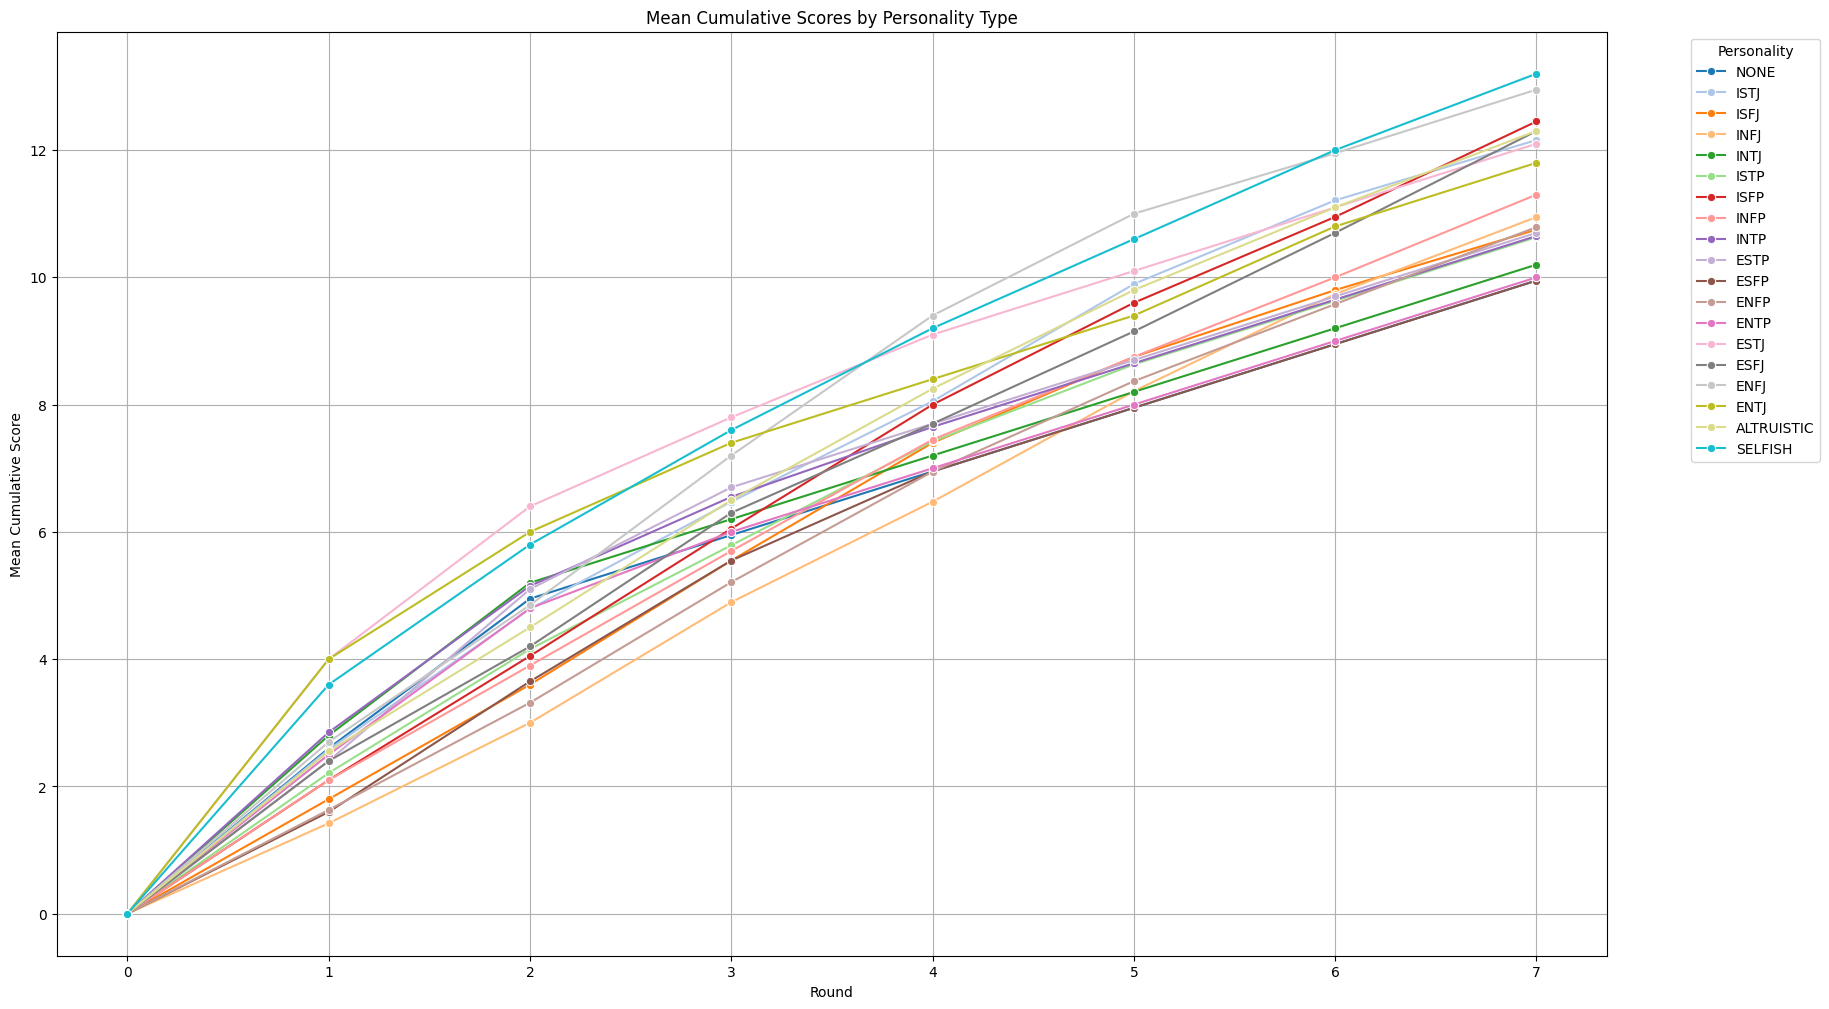

In [5]:
from collections import defaultdict

# Initialize a dictionary to store cumulative scores by personality
cumulative_scores_by_personality = defaultdict(list)

# Iterate through the dataframe and collect cumulative scores
for i, row in df.iterrows():
    for personality, scores in zip([row['personality_1'], row['personality_2']], [row['agent_1_cumulative_scores'], row['agent_2_cumulative_scores']]):
        cumulative_scores_by_personality[personality].append(scores)

# Calculate the mean cumulative scores for each personality
mean_cumulative_scores_by_personality = {}
for personality, scores_list in cumulative_scores_by_personality.items():
    # Transpose the list of scores to calculate the mean for each round
    transposed_scores = list(zip(*scores_list))
    mean_cumulative_scores = [sum(scores) / len(scores) for scores in transposed_scores]
    mean_cumulative_scores_by_personality[personality] = mean_cumulative_scores

# Print the mean cumulative scores for each personality
for personality, mean_scores in mean_cumulative_scores_by_personality.items():
    print(f"Personality: {personality}, Mean Cumulative Scores: {mean_scores}")
    
    # Create a DataFrame for plotting
    plot_data = []
    for personality, mean_scores in mean_cumulative_scores_by_personality.items():
        for round_num, score in enumerate(mean_scores):
            plot_data.append({'Personality': personality, 'Round': round_num, 'Mean Cumulative Score': score})

plot_df = pd.DataFrame(plot_data)

# Plot the mean cumulative scores for each personality
plt.figure(figsize=(20, 12))
sns.lineplot(data=plot_df, x='Round', y='Mean Cumulative Score', hue='Personality', palette='tab20', marker='o')
plt.title('Mean Cumulative Scores by Personality Type')
plt.xlabel('Round')
plt.ylabel('Mean Cumulative Score')
plt.legend(title='Personality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# truthfulness
- the altruitic is not much higher, because sometimes the other agent says it will defect and it defects. while the altruistic then wants to stick to the positive message but still mirrors the others aciton,
- this could be explained by different reasons: the prompt is way shorter, so it s not as strong/easy to follow for the agent
- maybe rename to honest

/tmp/ipykernel_1615872/1445845666.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_truthfulness, x='Personality', y='Truthfulness Percentage', palette='viridis')


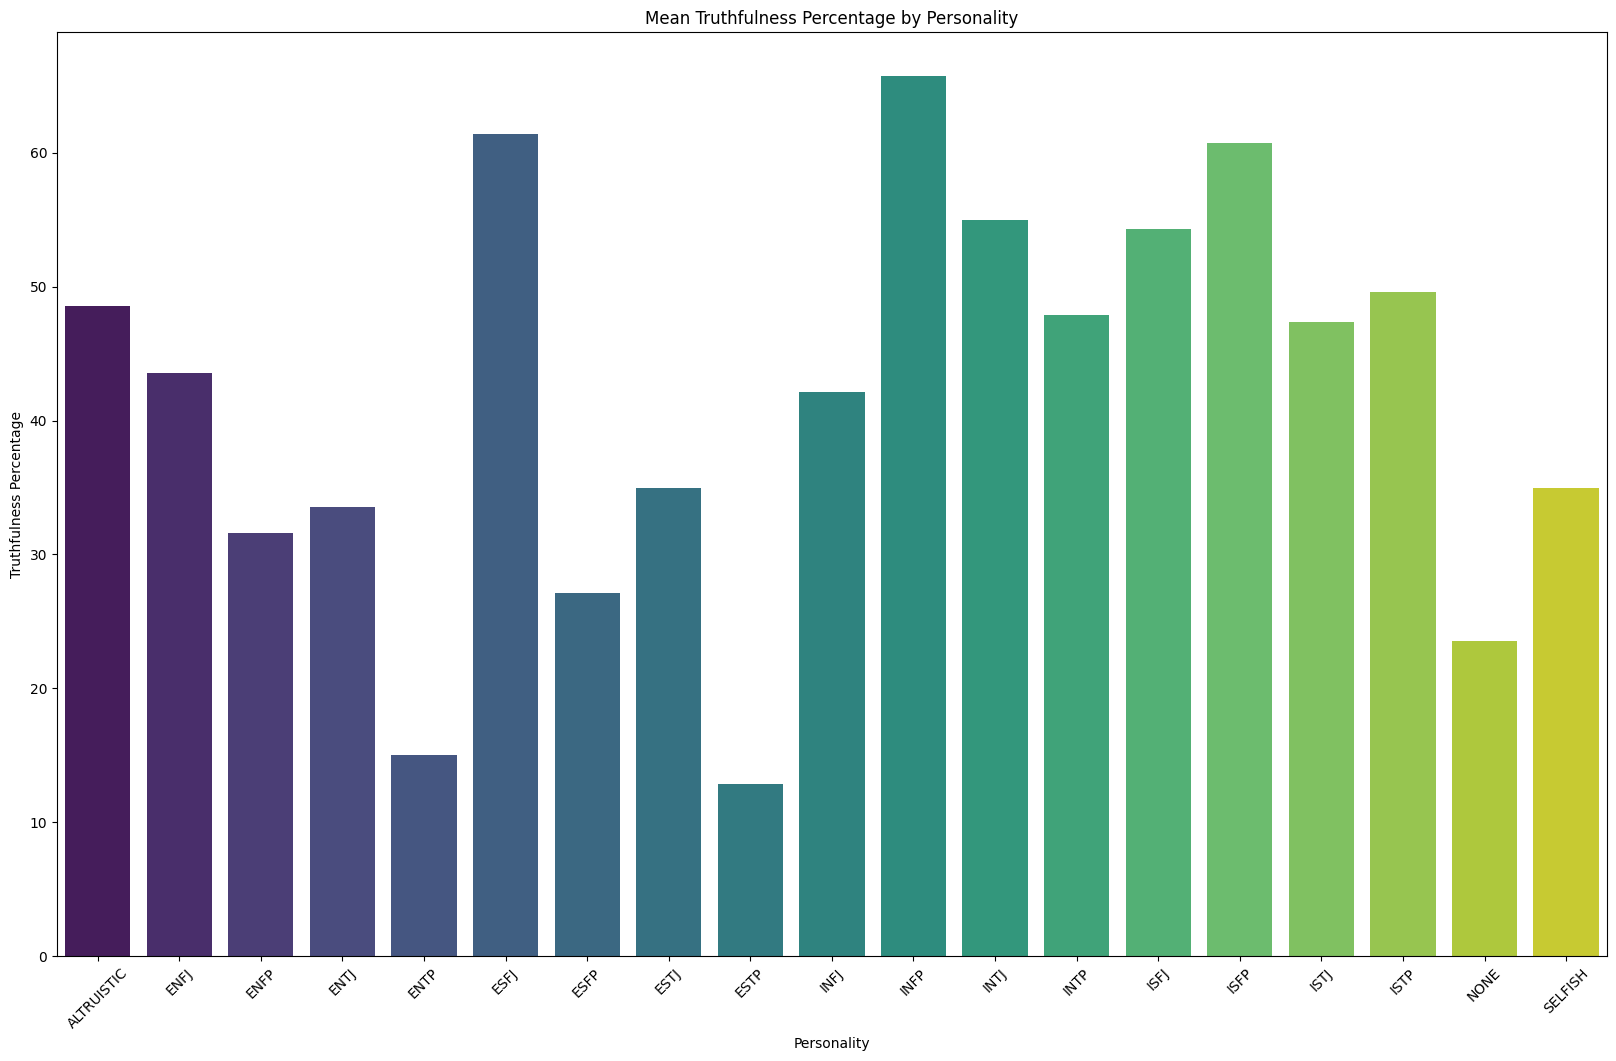

In [6]:
import ast

truthfulness_data = []

for i, row in df.iterrows():
    for personality, truthfulness in zip([row['personality_1'], row['personality_2']], [row['truthful_agent_1'], row['truthful_agent_2']]):
        try:
            truthfulness_list = ast.literal_eval(truthfulness) if isinstance(truthfulness, str) else truthfulness
            truthfulness_bool = [bool(t) for t in truthfulness_list]
            truthfulness_data.append({'Personality': personality, 'Truthful': sum(truthfulness_bool), 'Total': len(truthfulness_bool)})
        except (ValueError, SyntaxError):
            print(f"Skipping row {i} due to malformed data: {truthfulness}")

truthfulness_df = pd.DataFrame(truthfulness_data)
truthfulness_df['Truthfulness Percentage'] = truthfulness_df['Truthful'] / truthfulness_df['Total'] * 100

# Calculate the mean truthfulness percentage for each personality
mean_truthfulness = truthfulness_df.groupby('Personality')['Truthfulness Percentage'].mean().reset_index()

# Plot the mean truthfulness percentage for each personality
plt.figure(figsize=(20, 12))
sns.barplot(data=mean_truthfulness, x='Personality', y='Truthfulness Percentage', palette='viridis')
plt.title('Mean Truthfulness Percentage by Personality')
plt.xlabel('Personality')
plt.ylabel('Truthfulness Percentage')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_1615872/1688364116.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_1615872/1688364116.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_1615872/1688364116.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2'

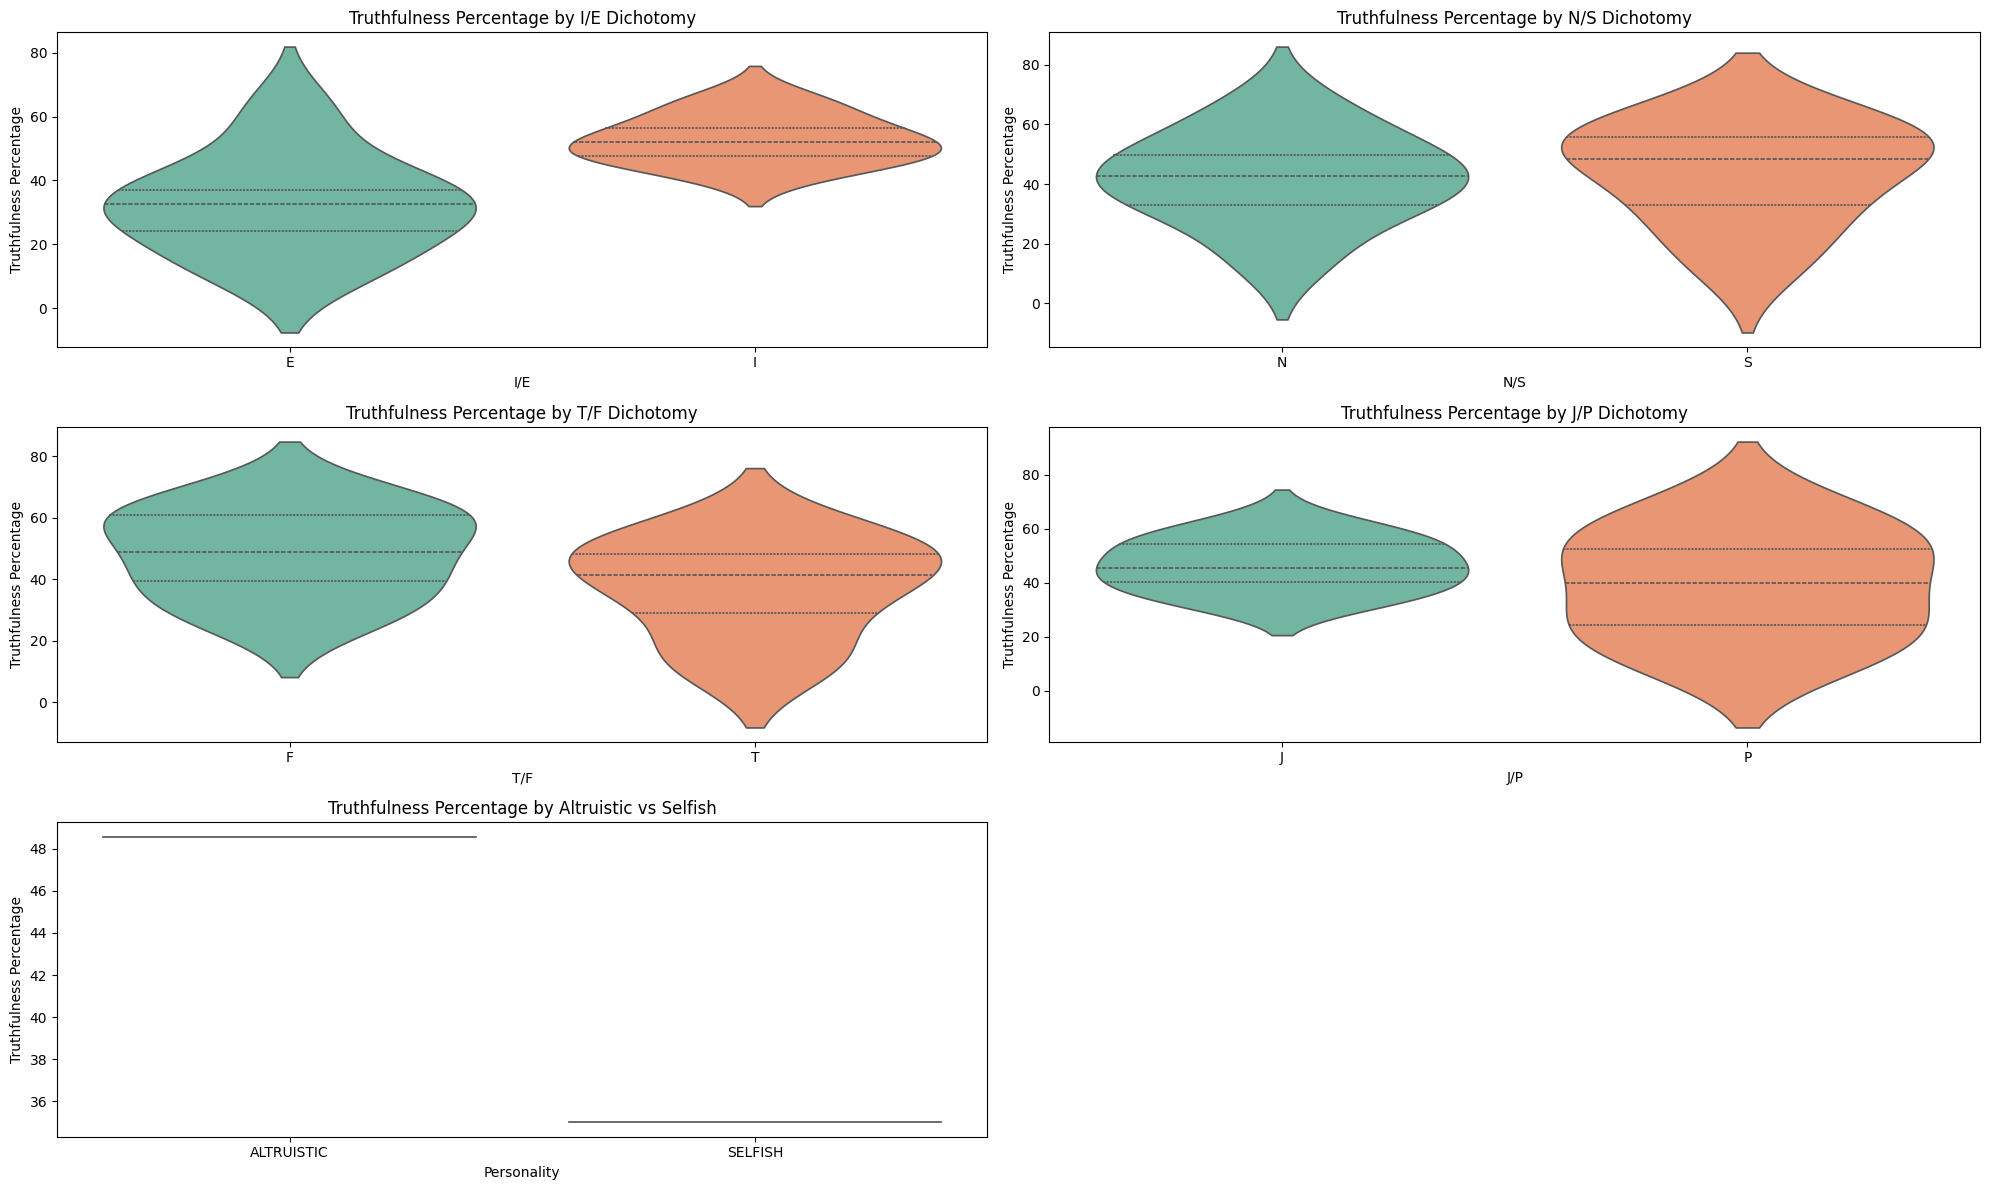

In [7]:
# Filter out the control groups
filtered_df = mean_truthfulness[~mean_truthfulness['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])]

# Create a new DataFrame to store the dichotomies
dichotomies_df = pd.DataFrame()

# Map each personality to its dichotomies
dichotomies_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
dichotomies_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
dichotomies_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
dichotomies_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')
dichotomies_df['Truthfulness Percentage'] = mean_truthfulness['Truthfulness Percentage']

# Plot the boxplots for each dichotomy
plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
sns.violinplot(data=dichotomies_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by I/E Dichotomy')

plt.subplot(3, 2, 2)
sns.violinplot(data=dichotomies_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by N/S Dichotomy')

plt.subplot(3, 2, 3)
sns.violinplot(data=dichotomies_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by T/F Dichotomy')

plt.subplot(3, 2, 4)
sns.violinplot(data=dichotomies_df, x='J/P', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by J/P Dichotomy')

plt.subplot(3, 2, 5)
sns.violinplot(data=mean_truthfulness[mean_truthfulness['Personality'].isin(['ALTRUISTIC', 'SELFISH'])], x='Personality', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by Altruistic vs Selfish')

plt.tight_layout()
plt.show()

# who lied first
- often, the agent stop being truthful because they keep getting lied to
- which is why i caught some pointers to show if the agent lied first in each conversation.
- we ignore the cases when the other agent defects first, even if they are being truthful about the fact theat they will defect.
- to explain why it looks like altruistic would lie ,first, but it s just a consequence of the other saying they will defect explictly.

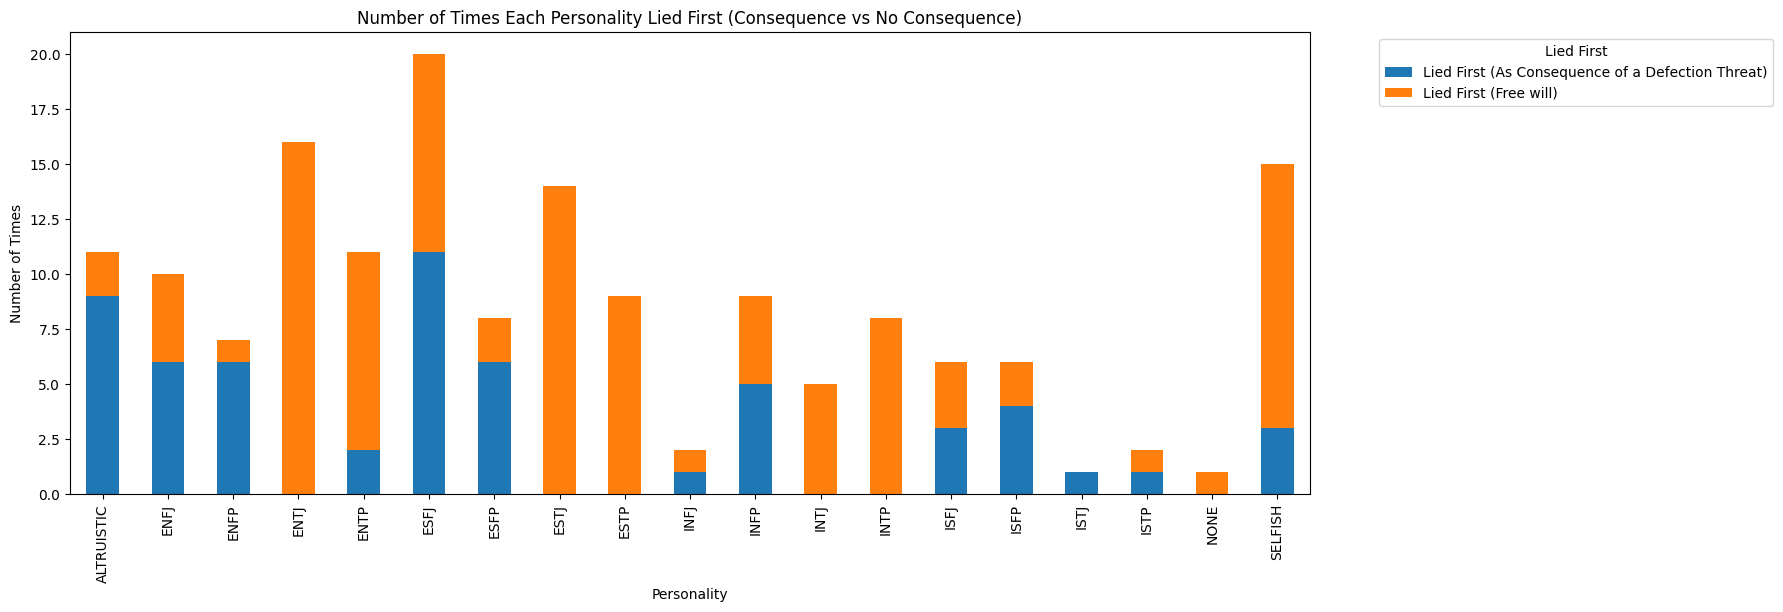

In [8]:
df['lied_first_1'] = [False] * len(df)
df['lied_first_2'] = [False] * len(df)
df['defected_first_1'] = [False] * len(df)
df['defected_first_2'] = [False] * len(df)

for i, row in df.iterrows():
    personality_1 = row['personality_1']
    personality_2 = row['personality_2']
    
    for truthful_1, truthful_2, intent_1, intent_2 in zip(row['truthful_agent_1'], row['truthful_agent_2'], row['intent_agent_1'], row['intent_agent_2']):
        if (truthful_1 == False) and (truthful_2 == True):
            df.at[i, 'lied_first_1'] = True
            break
        elif (truthful_1 == True) and (truthful_2 == False):
            df.at[i, 'lied_first_2'] = True
            break
    for action_1, action_2 in zip(row['agent_1_actions'], row['agent_2_actions']):
        if (action_1 == 'defect') and (action_2 == 'cooperate'):
            
            df.at[i, 'defected_first_1'] = True
            break
        elif (action_1 == 'cooperate') and (action_2 == 'defect'):
            df.at[i, 'defected_first_2'] = True
            break
        elif (action_1 == 'defect') and (action_2 == 'defect'):
            if (intent_1 == 'defect') and (intent_2 == 'cooperate'):
                df.at[i, 'defected_first_2'] = True
                break
            elif (intent_1 == 'cooperate') and (intent_2 == 'defect'):
                df.at[i, 'defected_first_1'] = True
                break
# Calculate the percentage of times each personality lied first
first_liars = df.groupby('personality_1')['lied_first_1'].sum().to_dict()
first_liars.update(df.groupby('personality_2')['lied_first_2'].sum().to_dict())

# Calculate the number of times each personality lied first and whether it was a consequence of being defected first
first_liars_consequence = df.groupby('personality_1')['defected_first_2'].sum().to_dict()
first_liars_consequence.update(df.groupby('personality_2')['defected_first_1'].sum().to_dict())

# Calculate the number of times each personality lied first without being defected first
first_liars_no_consequence = {k: abs(first_liars[k] - first_liars_consequence.get(k, 0)) for k in first_liars.keys()}

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Personality': list(first_liars.keys()),
    'Lied First (As Consequence of a Defection Threat)': list(first_liars_consequence.values()),
    'Lied First (Free will)': list(first_liars_no_consequence.values())
})

# Plot the bars with two colors
plot_data.set_index('Personality').plot(kind='bar', stacked=True, figsize=(16,6), color=['#1f77b4', '#ff7f0e'])
plt.title('Number of Times Each Personality Lied First (Consequence vs No Consequence)')
plt.xlabel('Personality')
plt.ylabel('Number of Times')
plt.legend(title='Lied First', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
 

## truthfulness
- truthfullness is defined by how many times the agent said the truth/total actions
- maybe also compare when we take into account if the lies were by free will and not as a consequence of defection

In [9]:
def calculate_how_truthfull(list_bools):
    return sum(list_bools) / len(list_bools)

# Extract the last value of cumulative scores and truthfulness for each agent
df['agent_1_final_score'] = df['agent_1_cumulative_scores'].apply(lambda x: x[-1])
df['agent_2_final_score'] = df['agent_2_cumulative_scores'].apply(lambda x: x[-1])
df['agent_1_final_truthfulness'] = df['truthful_agent_1'].apply(lambda x: calculate_how_truthfull(x))
df['agent_2_final_truthfulness'] = df['truthful_agent_2'].apply(lambda x: calculate_how_truthfull(x))

# Create a new DataFrame to store the correlation data
correlation_data = []

# Iterate through the dataframe and collect the necessary data
for i, row in df.iterrows():
    correlation_data.append({
        'Personality': row['personality_1'],
        'Final Score': row['agent_1_final_score'],
        'Truthfulness': row['agent_1_final_truthfulness']
    })
    correlation_data.append({
        'Personality': row['personality_2'],
        'Final Score': row['agent_2_final_score'],
        'Truthfulness': row['agent_2_final_truthfulness']
    })

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data)
correlation_df_groups = correlation_df.groupby('Personality').sum().reset_index()

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(correlation_df_groups[['Truthfulness']], correlation_df_groups[['Final Score']])

correlation_df_groups['Predicted Final Score'] = reg.predict(correlation_df_groups[['Truthfulness']])
correlation_df_groups

,Personality,Final Score,Truthfulness,Predicted Final Score
0,ALTRUISTIC,246,9.714286,227.930668
1,ENFJ,259,8.714286,225.361078
2,ENFP,205,6.000000,218.386476
3,ENTJ,236,6.714286,220.221898
4,ENTP,200,3.000000,210.677706
5,ESFJ,246,12.285714,234.538185
6,ESFP,199,5.428571,216.918139
7,ESTJ,242,7.000000,220.956066
8,ESTP,214,2.571429,209.576454
9,INFJ,208,8.000000,223.525656


## Linear Regression
- by making a linear regression, we can see how being more truthful, we get better scores
- to have a real simulation, we d need to also take into account the amount of population in each group. for the games.
- We can adda weight factor for that.
- our data assumes that there are as many of each type right now

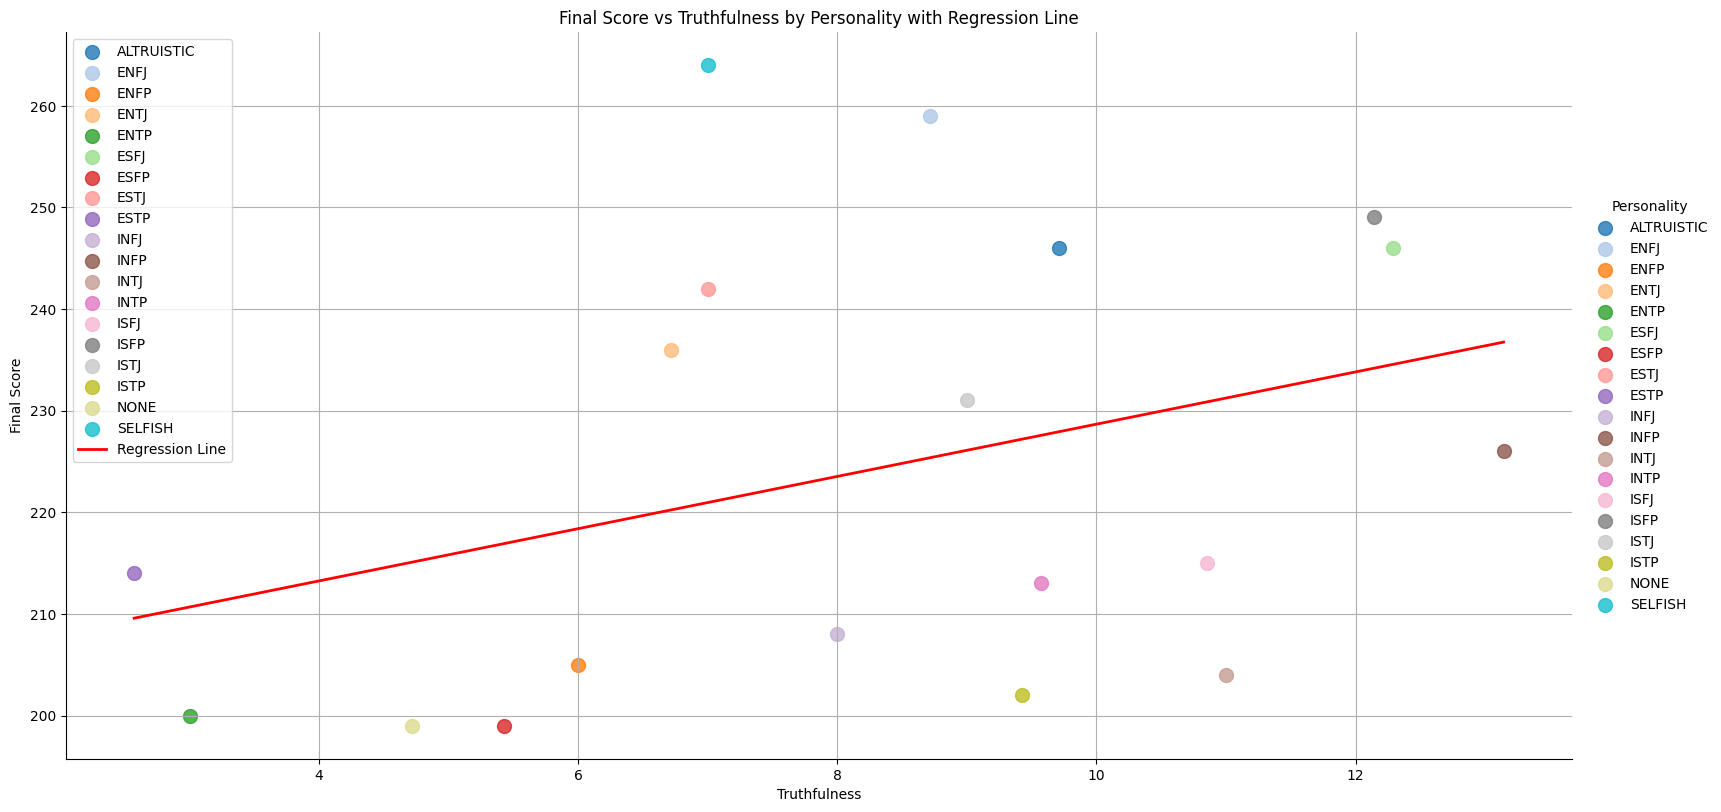

In [10]:
sns.lmplot(data=correlation_df_groups, x='Truthfulness', y='Final Score', hue='Personality', aspect=2, height=8, markers='o', palette='tab20', ci=None, scatter_kws={'s': 100})
sns.lineplot(x=correlation_df_groups['Truthfulness'], y=correlation_df_groups['Predicted Final Score'], color='red', linewidth=2, label='Regression Line')
plt.title('Final Score vs Truthfulness by Personality with Regression Line')
plt.xlabel('Truthfulness')
plt.ylabel('Final Score')
plt.grid(True)
plt.show()